<a href="https://colab.research.google.com/github/b-remy/score-estimation-comparison/blob/datasets/notebooks/TwoMoonsExperiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TFP implementation of the 2 moons distribution

In [ ]:
%pylab inline
import jax
import jax.numpy as np
import tensorflow_probability as tfp; tfp = tfp.experimental.substrates.jax
tfd = tfp.distributions

Populating the interactive namespace from numpy and matplotlib


In [ ]:
# This code is taken from make_moons in sklearn
resolution = 1024
outer_circ_x = np.cos(np.linspace(0, np.pi, resolution))
outer_circ_y = np.sin(np.linspace(0, np.pi, resolution))
inner_circ_x = 1 - np.cos(np.linspace(0, np.pi, resolution))
inner_circ_y = 1 - np.sin(np.linspace(0, np.pi, resolution)) - .5

X = np.append(outer_circ_x, inner_circ_x)
Y = np.append(outer_circ_y, inner_circ_y)
coords = np.vstack([X,Y])

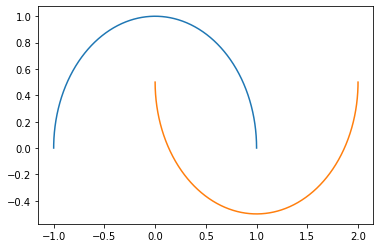

In [ ]:
plot(outer_circ_x,outer_circ_y)
plot(inner_circ_x,inner_circ_y)

In [ ]:
sigma=0.02
# We approximate the 2 moons with a large mixture
distribution = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(probs=np.ones(2*resolution)/resolution/2),
    components_distribution=tfd.MultivariateNormalDiag(loc=coords.T, scale_identity_multiplier=sigma) 
)

In [ ]:
coords.T.shape

(2048, 2)

In [ ]:
rng_key = jax.random.PRNGKey(seed=0)
samps = distribution.sample(10000, seed=rng_key)

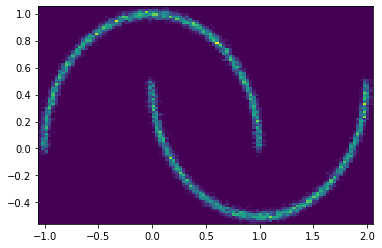

In [ ]:
# Plotting samples
hist2d(samps[:,0], samps[:,1],100);

In [ ]:
# But now we can also compute the gradients of log p :-)
grads = jax.vmap(jax.grad(distribution.log_prob))

In [ ]:
grads(np.array([0.,0.]).reshape([1,2]))

/usr/local/lib/python3.6/dist-packages/jax/numpy/lax_numpy.py:1601: FutureWarning: jax.numpy reductions won't accept lists and tuples in future versions, only scalars and ndarrays
  warnings.warn(msg, category=FutureWarning)


DeviceArray([[264.3321 , 132.16592]], dtype=float32)

In [ ]:
X = np.arange(-1.5, 2.5, 0.1)
Y = np.arange(-1, 1.5, 0.1)
points = stack(meshgrid(X, Y), axis=-1).reshape((-1, 2))
g = grads(points).reshape([len(Y), len(X),2])

/usr/local/lib/python3.6/dist-packages/jax/numpy/lax_numpy.py:1601: FutureWarning: jax.numpy reductions won't accept lists and tuples in future versions, only scalars and ndarrays
  warnings.warn(msg, category=FutureWarning)


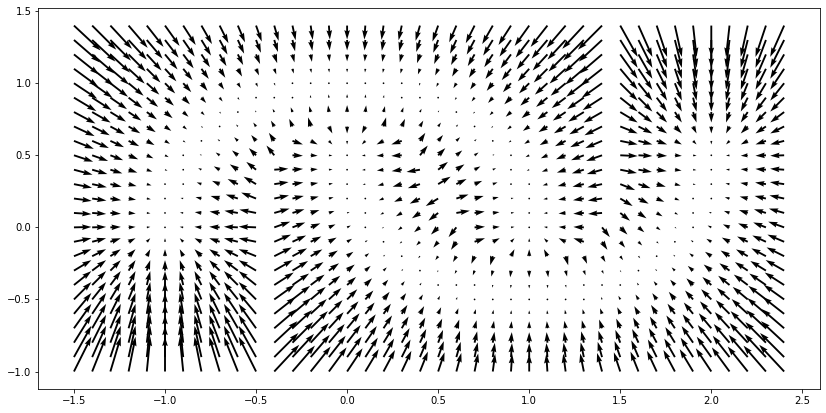

In [ ]:
figure(figsize=(14,7))
quiver(X, Y, g[:,:,0], g[:,:,1]);

In [ ]:
X = np.arange(-1.5, 2.5, 0.01)
Y = np.arange(-1, 1.5, 0.01)
points = stack(meshgrid(X, Y), axis=-1).reshape((-1, 2))
g = grads(points).reshape([len(Y), len(X),2])

/usr/local/lib/python3.6/dist-packages/jax/numpy/lax_numpy.py:1601: FutureWarning: jax.numpy reductions won't accept lists and tuples in future versions, only scalars and ndarrays
  warnings.warn(msg, category=FutureWarning)


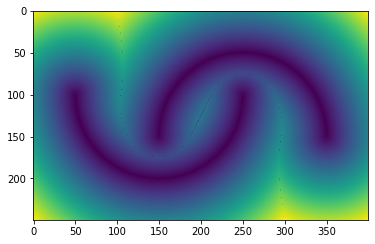

In [ ]:
imshow(np.sqrt(g[:,:,0]**2 + g[:,:,1]**2))

In [ ]:
# I shouldn't... but I can't resist trying out density learning 
!pip install --quiet flax
import numpy as onp
import flax
from flax import nn

In [ ]:
@nn.module
def Denoiser(x):
  # Encoder
  x = nn.Dense(x, 128)
  x = nn.BatchNorm(x)
  x = nn.leaky_relu(x)
  x = nn.Dense(x, 128)
  x = nn.BatchNorm(x)
  x = nn.leaky_relu(x)
  x = nn.Dense(x, 2)
  
  # Decoder
  x = nn.Dense(x, 128)
  x = nn.BatchNorm(x)
  x = nn.leaky_relu(x)
  x = nn.Dense(x, 128)
  x = nn.BatchNorm(x)
  x = nn.leaky_relu(x)
  x = nn.Dense(x, 2)
  return x

In [ ]:
batch_size = 512
step_size = 0.05
def get_batch(rng_key):
  dist = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(probs=np.ones(2*resolution)/resolution/2),
    components_distribution=tfd.MultivariateNormalDiag(loc=coords.T, scale_identity_multiplier=sigma) 
  )
  y = distribution.sample(batch_size, seed=rng_key)
  x = y + step_size * onp.random.randn(batch_size, 2)
  # x is a noisy sample, y is a sample from the distribution
  return {'x':x, 'y':y}

In [ ]:
# We now define some machinery to train the model under an l2 loss
@jax.jit
def train_step(optimizer, batch):
  def loss_fn(model):
    ypred = batch['x'] + model(batch['x'])
    loss = np.mean( (ypred - batch['y'])**2) 
    return loss
  l, grad = jax.value_and_grad(loss_fn)(optimizer.target)

  optimizer = optimizer.apply_gradient(grad)
  return optimizer, l

_, initial_params = Denoiser.init_by_shape(jax.random.PRNGKey(0),
                                           [((1, 2), np.float32)])

model = flax.nn.Model(Denoiser, initial_params)

optimizer = flax.optim.Adam(learning_rate=0.001).create(model)

losses = []
rng_key = jax.random.PRNGKey(1)

In [ ]:
for epoch in range(5000):
  rng_key, key = jax.random.split(rng_key)
  batch = get_batch(key)
  optimizer, l = train_step(optimizer, batch)
  losses.append(l)

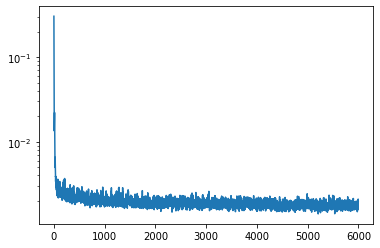

In [ ]:
semilogy(np.array(losses[:]), label='loss')

Ok... it's learning something

In [ ]:
X = np.arange(-1.5, 2.5, 0.1)
Y = np.arange(-1, 1.5, 0.1)
points = stack(meshgrid(X, Y), axis=-1).reshape((-1, 2))
g = (optimizer.target(points)).reshape([len(Y), len(X),2])

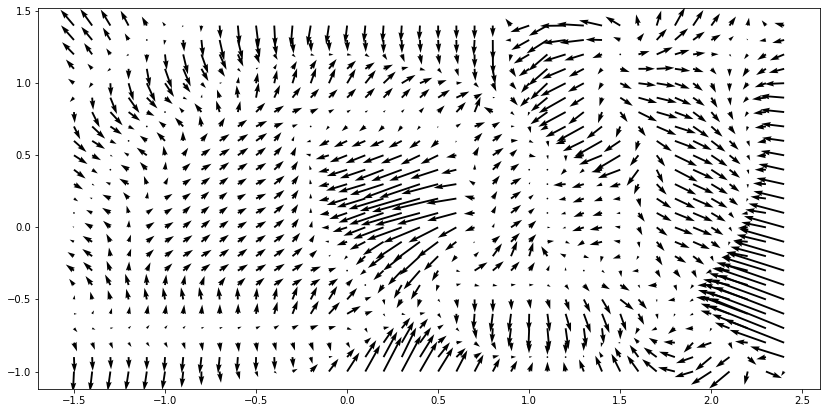

In [ ]:
figure(figsize=(14,7))
quiver(X, Y, g[:,:,0], g[:,:,1]);

If you squint... you can recognize the 2 moons

In [ ]:
X = np.arange(-1.5, 2.5, 0.01)
Y = np.arange(-1, 1.5, 0.01)
points = stack(meshgrid(X, Y), axis=-1).reshape((-1, 2))
g = (optimizer.target(points)).reshape([len(Y), len(X),2])

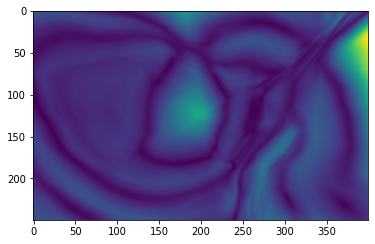

In [ ]:
imshow(np.sqrt(g[:,:,0]**2 + g[:,:,1]**2))

.... I mean.... at least it's pretty :-D

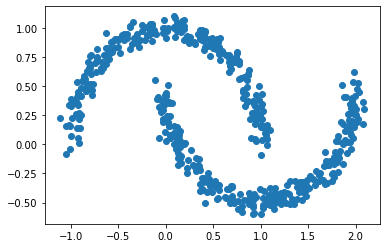

In [ ]:
# These are the noisy points
scatter(batch['x'][:,0], batch['x'][:,1])

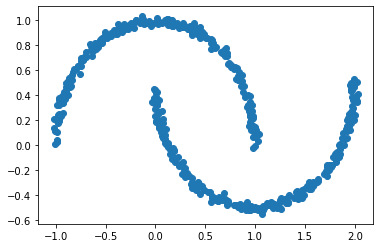

In [ ]:
# These are the true points position
scatter(batch['y'][:,0], batch['y'][:,1])

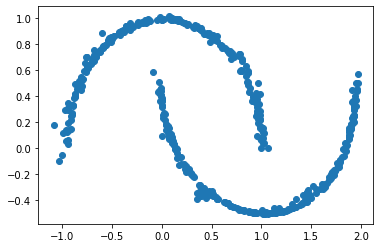

In [ ]:
# And this is what the denoiser gives us
ypred = batch['x'] + optimizer.target(batch['x'])
scatter(ypred[:,0], ypred[:,1])